In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mplt
import matplotlib as plt
import datetime as dati

In [64]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

In [65]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

In [66]:
train_csv = pd.read_csv("/home/federico/Git/datos-tp2-2c2020/data/friofrio/Train_TP2_Datos_2020-2C.csv",
        parse_dates = ['Account_Created_Date', 'Opportunity_Created_Date',
                       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date',
                       'Quote_Expiry_Date', 'Last_Modified_Date','Last_Activity' ])
# Limpio registros con muchos datos faltantes o inutiles
train_csv = train_csv.drop(columns= ['Prod_Category_A', 'Quote_Type',
                                 'Product_Category_B', 'Delivery_Terms',
                                 'Actual_Delivery_Date', 'Submitted_for_Approval',
                                 'Last_Activity','Price', 'Currency','Brand', 
                                 'Opportunity_Type', 'Size','Product_Type',
                                 'Account_Type', 'ASP_Currency', 'ASP_(converted)_Currency',
                                 'Total_Amount_Currency', 'Account_Name',
                                 'Opportunity_Name','Total_Taxable_Amount_Currency',
                                 'Product_Family', 'Product_Name'])

In [67]:
train_csv = train_csv.loc[(train_csv['Stage'] == 'Closed Won') | (train_csv['Stage'] == 'Closed Lost')]
train_csv['Oportunidad ganada'] = (train_csv['Stage'] == 'Closed Won').astype(int)

In [68]:
train_csv_numerics = train_csv.select_dtypes(include = np.number).fillna(0)

In [69]:
X = train_csv_numerics.drop(columns = 'Oportunidad ganada').fillna(0)
y = train_csv_numerics[['Oportunidad ganada']].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train = X_train.drop(columns = ['Opportunity_ID', 'ID'])
X_test = X_test.drop(columns = ['Opportunity_ID', 'ID'])

xgbr = xgb.XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 4,
    alpha = 10,
    n_estimators = 200,
    objective = 'binary:logistic')

xgbr.fit(X_train, y_train)

preds = xgbr.predict(X_test)

log_loss(y_test, preds, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.40456575140620943

In [70]:
train_csv_lucas = pd.read_csv('Features_agrupados_Train_Lucas.csv')

train_csv_lucas.drop(columns = ['Unnamed: 0'], inplace = True)

train_csv_lucas = train_csv_lucas.select_dtypes(include = np.number).fillna(0)

cols_to_use = train_csv_lucas.columns.difference(train_csv_numerics.columns)

train_csv_numerics_lucas = train_csv_numerics.replace([np.inf, -np.inf], np.nan)
train_csv_numerics_lucas = train_csv_numerics.join(
                    train_csv_lucas[cols_to_use], on = 'Opportunity_ID',
                    how = 'left').fillna(0)#.drop(columns = 'ID')
train_csv_numerics_lucas = train_csv_numerics_lucas.astype('float64')

train_csv_numerics_lucas = train_csv_numerics_lucas.replace([np.inf, -np.inf], np.nan)

In [71]:
train_csv_numerics_lucas.head()

,ID,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Opportunity_ID,ASP,ASP_(converted),Delivery_Year,TRF,...,Total_Amount_std,Total_Amount_sum,Total_Taxable_Amount_max,Total_Taxable_Amount_mean,Total_Taxable_Amount_median,Total_Taxable_Amount_min,Total_Taxable_Amount_std,Total_Taxable_Amount_sum,acount_age,delta_planed
0,27761.0,1.0,1.0,1.0,1.0,0.0,0.52,0.58817,2016.0,10.0,...,0.0,5272800.0,5272800.0,5272800.0,5272800.0,5272800.0,0.0,5272800.0,174.0,60.0
1,27760.0,0.0,0.0,0.0,0.0,1.0,0.53,0.59948,2016.0,0.0,...,0.0,48230.0,48230.0,48230.0,48230.0,48230.0,0.0,48230.0,174.0,2.0
2,27446.0,0.0,0.0,0.0,0.0,2.0,0.48,0.48000,2016.0,0.0,...,0.0,83865.6,83865.6,83865.6,83865.6,83865.6,0.0,83865.6,231.0,0.0
3,16808.0,1.0,0.0,1.0,0.0,3.0,0.53,0.53000,2018.0,14.0,...,0.0,7421881.5,7421881.5,7421881.5,7421881.5,7421881.5,0.0,7421881.5,864.0,58.0
4,16805.0,1.0,0.0,1.0,0.0,4.0,0.53,0.53000,2018.0,25.0,...,0.0,13357192.5,13357192.5,13357192.5,13357192.5,13357192.5,0.0,13357192.5,864.0,27.0


In [72]:
X = train_csv_numerics_lucas.drop(columns = ['Oportunidad ganada','ID', 'Opportunity_ID']).fillna(0)
y = train_csv_numerics_lucas[['Oportunidad ganada']].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

xgbr = xgb.XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 3,
    alpha = 10,
    n_estimators = 200,
    objective = 'binary:logistic')

xgbr.fit(X_train, y_train)

preds = xgbr.predict(X_test)

log_loss(y_test, preds, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.40983984091280257

In [73]:
print 'score train: ' + str(xgbr.score(X_train, y_train))
print 'score test:  ' + str(xgbr.score(X_test, y_test))

score train: 0.536208535940631
score test:  0.46956396997200905


In [74]:
train_csv_numerics_lucas_new = train_csv_numerics_lucas
train_csv_numerics_lucas_new['Precio necesita aprobacion'] = (train_csv_numerics_lucas_new['Pricing, Delivery_Terms_Quote_Appr'] == 1)
train_csv_numerics_lucas_new['Precio aprobado'] = (train_csv_numerics_lucas_new['Pricing, Delivery_Terms_Approved'] == 1)
train_csv_numerics_lucas_new['Precio necesita aprobacion'] = train_csv_numerics_lucas_new['Precio necesita aprobacion'].astype(int)
train_csv_numerics_lucas_new['Precio aprobado'] = train_csv_numerics_lucas_new['Precio aprobado'].astype(int)
train_csv_numerics_lucas_new = train_csv_numerics_lucas_new.drop(columns = ['Pricing, Delivery_Terms_Quote_Appr',
                                                    'Pricing, Delivery_Terms_Approved'])

aux = train_csv_numerics_lucas_new.groupby('Opportunity_ID')\
    .agg({'Precio necesita aprobacion':'sum', 'Precio aprobado':'sum'})
aux.reset_index(inplace=True)
train_csv_numerics_lucas_new = train_csv_numerics_lucas_new\
                            .drop(columns = ['Precio aprobado','Precio necesita aprobacion'])\
                            .merge(aux, on = 'Opportunity_ID', how = 'left')
train_csv_numerics_lucas_new = train_csv_numerics_lucas_new.select_dtypes(include = np.number).fillna(0)
train_csv_numerics_lucas_new.drop(columns = ['Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_0_Approved'], inplace = True)
train_csv_numerics_lucas_new.head()

,ID,Opportunity_ID,ASP,ASP_(converted),Delivery_Year,TRF,Total_Amount,Total_Taxable_Amount,Oportunidad ganada,ASP_(converted)_max,...,Total_Taxable_Amount_max,Total_Taxable_Amount_mean,Total_Taxable_Amount_median,Total_Taxable_Amount_min,Total_Taxable_Amount_std,Total_Taxable_Amount_sum,acount_age,delta_planed,Precio necesita aprobacion,Precio aprobado
0,27761.0,0.0,0.52,0.58817,2016.0,10.0,5272800.0,5272800.0,0.0,0.58817,...,5272800.0,5272800.0,5272800.0,5272800.0,0.0,5272800.0,174.0,60.0,1,1
1,27760.0,1.0,0.53,0.59948,2016.0,0.0,48230.0,48230.0,1.0,0.59948,...,48230.0,48230.0,48230.0,48230.0,0.0,48230.0,174.0,2.0,0,0
2,27446.0,2.0,0.48,0.48000,2016.0,0.0,83865.6,83865.6,1.0,0.48000,...,83865.6,83865.6,83865.6,83865.6,0.0,83865.6,231.0,0.0,0,0
3,16808.0,3.0,0.53,0.53000,2018.0,14.0,7421881.5,7421881.5,0.0,0.53000,...,7421881.5,7421881.5,7421881.5,7421881.5,0.0,7421881.5,864.0,58.0,1,0
4,16805.0,4.0,0.53,0.53000,2018.0,25.0,13357192.5,13357192.5,0.0,0.53000,...,13357192.5,13357192.5,13357192.5,13357192.5,0.0,13357192.5,864.0,27.0,1,0


In [75]:
X = train_csv_numerics_lucas_new.drop(columns = ['Oportunidad ganada','ID', 'Opportunity_ID']).fillna(0)

y = train_csv_numerics_lucas_new[['Oportunidad ganada']].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

xgbr = xgb.XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 3,
    alpha = 10,
    n_estimators = 200,
    objective = 'binary:logistic')

xgbr.fit(X_train, y_train)

preds = xgbr.predict(X_test)

log_loss(y_test, preds, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.3999590643557207

In [76]:
print 'score train: ' + str(xgbr.score(X_train, y_train))
print 'score test:  ' + str(xgbr.score(X_test, y_test))

score train: 0.5448885473358409
score test:  0.4804271277723454


In [89]:
pivoted = train_csv[['Opportunity_ID','Delivery_Quarter']].pivot_table(index = 'Opportunity_ID',columns = 'Delivery_Quarter',aggfunc = {'Delivery_Quarter':'count'}).fillna(0).reset_index()

pivoted = pivoted.set_index('Opportunity_ID')
pivoted.columns = pivoted.columns.droplevel(0)
pivoted = pivoted.reset_index()

quarter_numeric = train_csv[['ID','Delivery_Quarter']]
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q1'] = 1
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q2'] = 2
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q3'] = 3
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q4'] = 4

train_csv_numerics_quarter = train_csv_numerics_lucas_new.merge(pivoted, on = 'Opportunity_ID')
train_csv_numerics_quarter = train_csv_numerics_quarter.merge(quarter_numeric, on = 'ID')

/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/federico/.local/lib/python2.7/site-packa

In [90]:
train_csv_numerics_quarter.head()

,ID,Opportunity_ID,ASP,ASP_(converted),Delivery_Year,TRF,Total_Amount,Total_Taxable_Amount,Oportunidad ganada,ASP_(converted)_max,...,Total_Taxable_Amount_sum,acount_age,delta_planed,Precio necesita aprobacion,Precio aprobado,Q1,Q2,Q3,Q4,Delivery_Quarter
0,27761.0,0.0,0.52,0.58817,2016.0,10.0,5272800.0,5272800.0,0.0,0.58817,...,5272800.0,174.0,60.0,1,1,0.0,1.0,0.0,0.0,2
1,27760.0,1.0,0.53,0.59948,2016.0,0.0,48230.0,48230.0,1.0,0.59948,...,48230.0,174.0,2.0,0,0,1.0,0.0,0.0,0.0,1
2,27446.0,2.0,0.48,0.48000,2016.0,0.0,83865.6,83865.6,1.0,0.48000,...,83865.6,231.0,0.0,0,0,1.0,0.0,0.0,0.0,1
3,16808.0,3.0,0.53,0.53000,2018.0,14.0,7421881.5,7421881.5,0.0,0.53000,...,7421881.5,864.0,58.0,1,0,1.0,0.0,0.0,0.0,1
4,16805.0,4.0,0.53,0.53000,2018.0,25.0,13357192.5,13357192.5,0.0,0.53000,...,13357192.5,864.0,27.0,1,0,1.0,0.0,0.0,0.0,1


In [91]:
X = train_csv_numerics_quarter.drop(columns = ['Oportunidad ganada','ID', 'Opportunity_ID']).fillna(0)

y = train_csv_numerics_quarter[['Oportunidad ganada']].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

xgbr = xgb.XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 3,
    alpha = 10,
    n_estimators = 200,
    objective = 'binary:logistic')

xgbr.fit(X_train, y_train)

preds = xgbr.predict(X_test)

log_loss(y_test, preds, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.3967773091602466

In [92]:
print 'score train: ' + str(xgbr.score(X_train, y_train))
print 'score test:  ' + str(xgbr.score(X_test, y_test))

score train: 0.5438775597543658
score test:  0.48501246960141586


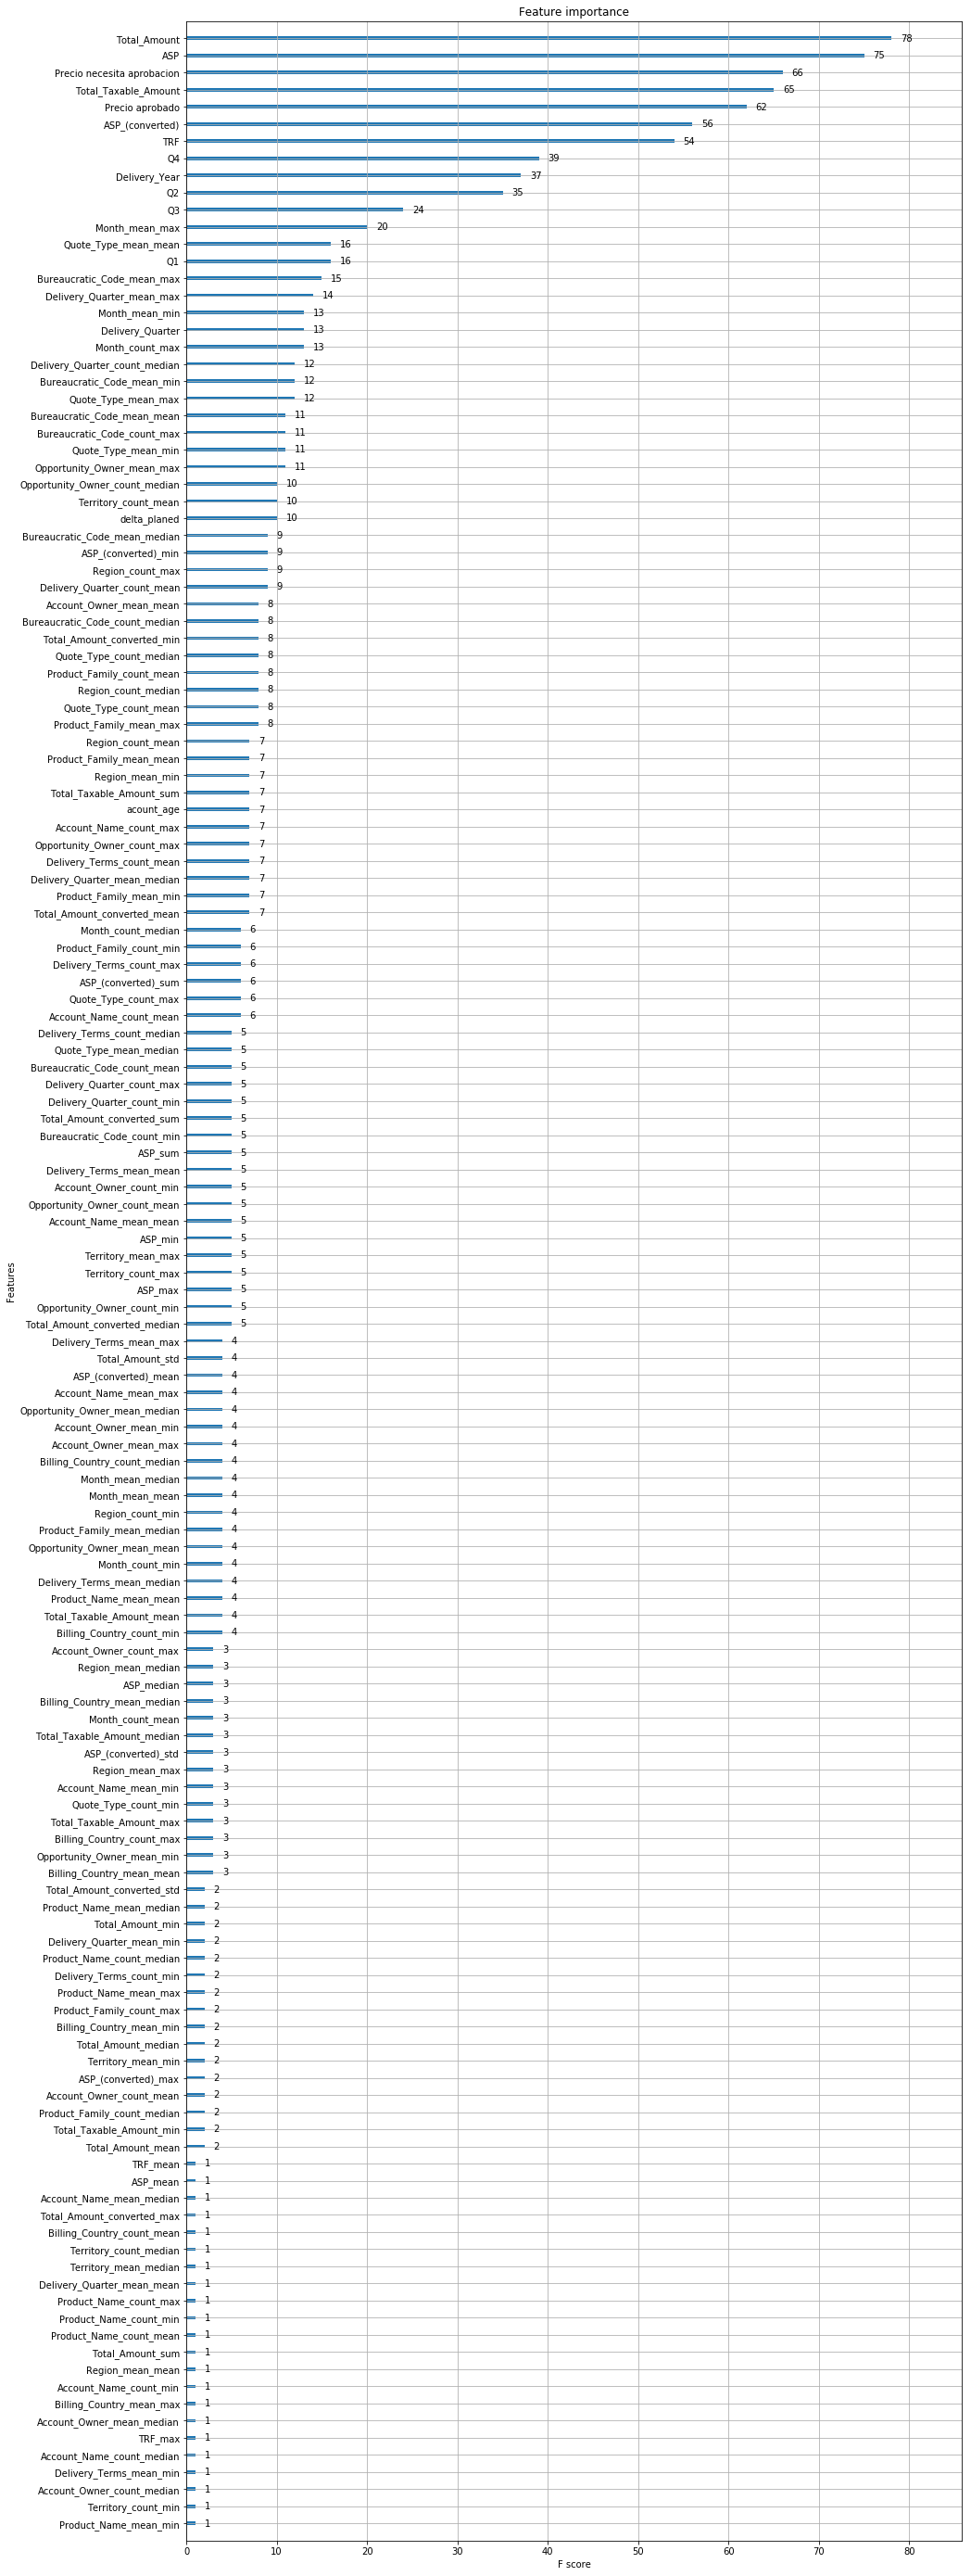

In [93]:
fig, ax = mplt.subplots(1,1,figsize=(15,50))
xgb.plot_importance(xgbr, ax = ax)

In [94]:
feature_importances = \
    pd.DataFrame(xgbr.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance'])
list_least_important = list(feature_importances.nsmallest(10, 'importance').reset_index()['index'])
list_least_important

['ASP_(converted)_median',
 'ASP_std',
 'TRF_median',
 'TRF_min',
 'TRF_std',
 'TRF_sum',
 'Territory_mean_mean',
 'Total_Amount_max',
 'Total_Taxable_Amount_std',
 'ASP_mean']

In [95]:
dropped = train_csv_numerics_quarter.drop(columns = 
['ASP_(converted)_median',
 'ASP_std',
 'TRF_median',
 'TRF_min',
 'TRF_std',
 'TRF_sum',
 'Territory_mean_mean',
 'Total_Amount_max',
 'Total_Taxable_Amount_std',
 'ASP_mean'])

In [96]:
X = dropped.drop(columns = ['Oportunidad ganada','ID', 'Opportunity_ID']).fillna(0)

y = dropped[['Oportunidad ganada']].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

xgbr_dropped = xgb.XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 3,
    alpha = 10,
    n_estimators = 200,
    objective = 'binary:logistic')

xgbr_dropped.fit(X_train, y_train)

preds = xgbr_dropped.predict(X_test)

log_loss(y_test, preds, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.3977917689819861

In [97]:
print 'score train: ' + str(xgbr_dropped.score(X_train, y_train))
print 'score test:  ' + str(xgbr_dropped.score(X_test, y_test))

score train: 0.5433968549627132
score test:  0.4835395475098414


In [283]:
dataset = train_csv
dataset['count'] = 1
dataset['TRF promedio'] = dataset['TRF']
dataset['TRF estandar'] = dataset['TRF']
oportunidades = dataset.groupby('Opportunity_ID').agg({
    'Total_Amount': sum , 'Stage': 'first', 'count': 'count',
    'Opportunity_Owner':'first','Opportunity_Created_Date': 'first','TRF promedio':'mean',
    'TRF estandar':'std'}).reset_index()

oportunidades['Grupo'] = oportunidades.Stage.shift().ne(dataset['Stage']).cumsum()
oportunidades_owner = oportunidades.sort_values(by=['Opportunity_Owner', 'Opportunity_Created_Date'])
oportunidades_owner['Grupo'] = oportunidades_owner.groupby('Opportunity_Owner').Stage.shift().ne(dataset['Stage']).cumsum()
oportunidades_owner.groupby(['Opportunity_Owner', 'Grupo']).size().reset_index(level=1, drop=True)

oportunidades_won_owner = oportunidades_owner.loc[oportunidades_owner['Stage'] == 'Closed Won']
oportunidades_loss_owner = oportunidades_owner.loc[oportunidades_owner['Stage'] == 'Closed Lost']

oportunidades_won = oportunidades_owner.loc[(oportunidades_owner['Stage']=='Closed Won')]
oportunidades_lost = oportunidades_owner.loc[(oportunidades_owner['Stage']=='Closed Lost')]

grouped_won_owner = oportunidades_won_owner.groupby(['Grupo','Opportunity_Owner'])\
                    .agg({'count':'count'}).reset_index().rename(columns = {'count':'count_won'})
grouped_loss_owner = oportunidades_loss_owner.groupby(['Grupo','Opportunity_Owner'])\
                    .agg({'count':'count'}).reset_index().rename(columns = {'count':'count_lost'})

In [284]:
prueba = oportunidades.merge(grouped_loss_owner.reset_index(), how = 'inner', on = ['Opportunity_Owner','Grupo'])
prueba = prueba.merge(grouped_won_owner.reset_index(), how = 'inner', on = ['Opportunity_Owner','Grupo'])
prueba = prueba[['Opportunity_ID','count_lost','count_won']].select_dtypes(include = np.number).fillna(0)
train_csv_numerics_previous = train_csv_numerics_quarter.merge(prueba, on = 'Opportunity_ID', how = 'left')

In [285]:
train_csv_numerics_previous.head()

,ID,Opportunity_ID,ASP,ASP_(converted),Delivery_Year,TRF,Total_Amount,Total_Taxable_Amount,Oportunidad ganada,ASP_(converted)_max,...,acount_age,delta_planed,Precio necesita aprobacion,Precio aprobado,Q1,Q2,Q3,Q4,count_lost,count_won
0,27761.0,0.0,0.52,0.58817,2016.0,10.0,5272800.0,5272800.0,0.0,0.58817,...,174.0,60.0,1,1,0.0,1.0,0.0,0.0,NaN,NaN
1,27760.0,1.0,0.53,0.59948,2016.0,0.0,48230.0,48230.0,1.0,0.59948,...,174.0,2.0,0,0,1.0,0.0,0.0,0.0,NaN,NaN
2,27446.0,2.0,0.48,0.48000,2016.0,0.0,83865.6,83865.6,1.0,0.48000,...,231.0,0.0,0,0,1.0,0.0,0.0,0.0,NaN,NaN
3,16808.0,3.0,0.53,0.53000,2018.0,14.0,7421881.5,7421881.5,0.0,0.53000,...,864.0,58.0,1,0,1.0,0.0,0.0,0.0,NaN,NaN
4,16805.0,4.0,0.53,0.53000,2018.0,25.0,13357192.5,13357192.5,0.0,0.53000,...,864.0,27.0,1,0,1.0,0.0,0.0,0.0,NaN,NaN


In [286]:
X = train_csv_numerics_previous.drop(columns = ['Oportunidad ganada','ID','Opportunity_ID']).fillna(0)
y = train_csv_numerics_previous[['Oportunidad ganada']].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

xgbr = xgb.XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 3,
    alpha = 10,
    n_estimators = 200,
    objective = 'binary:logistic')

xgbr.fit(X_train, y_train)

preds = xgbr.predict(X_test)

log_loss(y_test, preds, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.3919478818745059

In [287]:
print 'score train: ' + str(xgbr.score(X_train, y_train))
print 'score test:  ' + str(xgbr.score(X_test, y_test))

score train: 0.5479421417950765
score test:  0.4901803761628888


In [288]:
feature_importances = \
    pd.DataFrame(xgbr.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance'])
list_least_important = list(feature_importances.nsmallest(10, 'importance').reset_index()['index'])
list_least_important

['Billing_Country_count_mean',
 'Bureaucratic_Code_count_min',
 'Delivery_Terms_mean_min',
 'Product_Family_count_mean',
 'Product_Name_count_max',
 'TRF_mean',
 'TRF_median',
 'TRF_min',
 'TRF_std',
 'TRF_sum']

In [237]:
dropped = train_csv_numerics_previous.drop(columns = 
['Billing_Country_count_mean',
 'Bureaucratic_Code_count_min',
 'Delivery_Terms_mean_min',
 'Product_Family_count_mean',
 'Product_Name_count_max',
 'TRF_mean',
 'TRF_median',
 'TRF_min',
 'TRF_std',
 'TRF_sum'])

In [238]:
dropped.head()

,ID,Opportunity_ID,ASP,ASP_(converted),Delivery_Year,TRF,Total_Amount,Total_Taxable_Amount,Oportunidad ganada,ASP_(converted)_max,...,acount_age,delta_planed,Precio necesita aprobacion,Precio aprobado,Q1,Q2,Q3,Q4,count_lost,count_won
0,27761.0,0.0,0.52,0.58817,2016.0,10.0,5272800.0,5272800.0,0.0,0.58817,...,174.0,60.0,1,1,0.0,1.0,0.0,0.0,NaN,NaN
1,27760.0,1.0,0.53,0.59948,2016.0,0.0,48230.0,48230.0,1.0,0.59948,...,174.0,2.0,0,0,1.0,0.0,0.0,0.0,NaN,NaN
2,27446.0,2.0,0.48,0.48000,2016.0,0.0,83865.6,83865.6,1.0,0.48000,...,231.0,0.0,0,0,1.0,0.0,0.0,0.0,NaN,NaN
3,16808.0,3.0,0.53,0.53000,2018.0,14.0,7421881.5,7421881.5,0.0,0.53000,...,864.0,58.0,1,0,1.0,0.0,0.0,0.0,NaN,NaN
4,16805.0,4.0,0.53,0.53000,2018.0,25.0,13357192.5,13357192.5,0.0,0.53000,...,864.0,27.0,1,0,1.0,0.0,0.0,0.0,NaN,NaN


In [239]:
X = dropped.drop(columns = ['Oportunidad ganada','Opportunity_ID','ID']).fillna(0)
y = dropped[['Oportunidad ganada']].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

xgbr_dropped = xgb.XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 3,
    alpha = 10,
    n_estimators = 200,
    objective = 'binary:logistic')

xgbr_dropped.fit(X_train, y_train)

preds = xgbr_dropped.predict(X_test)

log_loss(y_test, preds, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.388748753644662

In [256]:
X_train.head()

,ASP,ASP_(converted),Delivery_Year,TRF,Total_Amount,Total_Taxable_Amount,ASP_(converted)_max,ASP_(converted)_mean,ASP_(converted)_median,ASP_(converted)_min,...,acount_age,delta_planed,Precio necesita aprobacion,Precio aprobado,Q1,Q2,Q3,Q4,count_lost,count_won
9798,0.390,0.390,2017.0,0.0,79170.0,79170.0,0.58437,0.58437,0.58437,0.58437,...,925.0,0.0,1,1,0.0,0.0,0.0,1.0,0.0,0.0
10709,0.000,0.000,2017.0,0.0,6200.0,620175.0,0.40154,0.40154,0.40154,0.40154,...,37.0,0.0,6,6,0.0,0.0,0.0,6.0,0.0,0.0
5593,0.365,0.365,2017.0,21.0,7703325.0,0.0,0.41850,0.41850,0.41850,0.41850,...,636.0,4.0,1,0,1.0,0.0,0.0,0.0,0.0,0.0
16304,0.000,0.000,2016.0,0.0,12800.0,6995400.0,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,6,0,0.0,6.0,0.0,0.0,0.0,0.0
4725,0.000,0.000,2016.0,0.0,6200.0,628000.0,0.39000,0.39000,0.39000,0.39000,...,0.0,30.0,5,5,0.0,0.0,0.0,5.0,0.0,0.0


In [240]:
print 'score train: ' + str(xgbr_dropped.score(X_train, y_train))
print 'score test:  ' + str(xgbr_dropped.score(X_test, y_test))

score train: 0.556563241506224
score test:  0.4959601822257518


In [126]:
test_csv = pd.read_csv("/home/federico/Git/datos-tp2-2c2020/data/friofrio/Test_TP2_Datos_2020-2C.csv",
        parse_dates = ['Account_Created_Date', 'Opportunity_Created_Date',
                       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date',
                       'Quote_Expiry_Date', 'Last_Modified_Date','Last_Activity' ])
# Limpio registros con muchos datos faltantes o inutiles
test_csv = test_csv.drop(columns= ['Prod_Category_A', 'Quote_Type',
                                 'Product_Category_B', 'Delivery_Terms',
                                 'Actual_Delivery_Date', 'Submitted_for_Approval',
                                 'Last_Activity','Price', 'Currency','Brand', 
                                 'Opportunity_Type', 'Size','Product_Type',
                                 'Account_Type', 'ASP_Currency', 'ASP_(converted)_Currency',
                                 'Total_Amount_Currency', 'Account_Name',
                                 'Opportunity_Name','Total_Taxable_Amount_Currency',
                                 'Product_Family', 'Product_Name'])

In [127]:
X_test_to_submit = test_csv.select_dtypes(include = np.number).fillna(0)
cols_to_use = train_csv_lucas.columns.difference(X_test_to_submit.columns)
X_test_to_submit = X_test_to_submit.join(
                    train_csv_lucas[cols_to_use], on = 'Opportunity_ID',
                    how = 'left').fillna(0)

X_test_to_submit['Precio necesita aprobacion'] = (X_test_to_submit['Pricing, Delivery_Terms_Quote_Appr'] == 1)
X_test_to_submit['Precio aprobado'] = (X_test_to_submit['Pricing, Delivery_Terms_Approved'] == 1)
X_test_to_submit['Precio necesita aprobacion'] = X_test_to_submit['Precio necesita aprobacion'].astype(int)
X_test_to_submit['Precio aprobado'] = X_test_to_submit['Precio aprobado'].astype(int)
X_test_to_submit = X_test_to_submit.drop(columns = ['Pricing, Delivery_Terms_Quote_Appr',
                                                    'Pricing, Delivery_Terms_Approved'])

a = X_test_to_submit.groupby('Opportunity_ID')\
    .agg({'Precio necesita aprobacion':'sum', 'Precio aprobado':'sum'})
a.reset_index(inplace=True)
X_test_to_submit = X_test_to_submit\
                            .drop(columns = ['Precio aprobado','Precio necesita aprobacion'])\
                            .merge(a, on = 'Opportunity_ID', how = 'left')
X_test_to_submit = X_test_to_submit.select_dtypes(include = np.number).fillna(0)
X_test_to_submit.drop(columns = ['Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_0_Approved'], inplace = True)

pivoted = test_csv[['Opportunity_ID','Delivery_Quarter']].pivot_table(
                    index = 'Opportunity_ID',
                    columns = 'Delivery_Quarter',
                    aggfunc = {'Delivery_Quarter':'count'})\
                    .fillna(0).reset_index()

pivoted = pivoted.set_index('Opportunity_ID')
pivoted.columns = pivoted.columns.droplevel(0)
pivoted = pivoted.reset_index()

quarter_numeric = test_csv[['ID','Delivery_Quarter']]
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q1'] = 1
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q2'] = 2
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q3'] = 3
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q4'] = 4

X_test_to_submit = X_test_to_submit.merge(pivoted, on = 'Opportunity_ID')
X_test_to_submit = X_test_to_submit.merge(quarter_numeric, on = 'ID')

/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set o

In [128]:
X_test_to_submit.head()

,ID,Opportunity_ID,ASP,ASP_(converted),Delivery_Year,TRF,Total_Amount,Total_Taxable_Amount,ASP_(converted)_max,ASP_(converted)_mean,...,Total_Taxable_Amount_sum,acount_age,delta_planed,Precio necesita aprobacion,Precio aprobado,Q1,Q2,Q3,Q4,Delivery_Quarter
0,6140,10689,0.325,0.36761,2019,0,162240.0,367419.0,0.0,0.0,...,0.0,0.0,0.0,3,3,0.0,3.0,0.0,0.0,2
1,6146,10689,0.320,0.36195,2019,0,78624.0,367419.0,0.0,0.0,...,0.0,0.0,0.0,3,3,0.0,3.0,0.0,0.0,2
2,6151,10689,0.275,0.31105,2019,0,126555.0,367419.0,0.0,0.0,...,0.0,0.0,0.0,3,3,0.0,3.0,0.0,0.0,2
3,6118,10690,0.325,0.36761,2019,1,243360.0,757783.5,0.0,0.0,...,0.0,0.0,0.0,5,5,0.0,5.0,0.0,0.0,2
4,6124,10690,0.320,0.36195,2019,0,157248.0,757783.5,0.0,0.0,...,0.0,0.0,0.0,5,5,0.0,5.0,0.0,0.0,2


In [129]:
preds_to_submit = xgbr.predict(X_test_to_submit.drop(columns = ['Opportunity_ID','ID']))

X_test_to_submit['Target'] = preds_to_submit.astype('float32')

result = X_test_to_submit[['Opportunity_ID','Target']].groupby(['Opportunity_ID']).mean()
result.reset_index(inplace=True)

result.to_csv('predicciones_XGB.csv', index = False)

In [130]:
results_rf = pd.read_csv('predicciones_RF.csv')

In [131]:
result_merged = results_rf.merge(result, left_index = True, right_index = True)
result_merged.head()

,Opportunity_ID_x,Target_x,Opportunity_ID_y,Target_y
0,10689,0.643591,10689,0.676183
1,10690,0.636199,10690,0.670559
2,10691,0.789023,10691,0.785219
3,10692,0.713292,10692,0.754720
4,10693,0.787858,10693,0.720536


In [132]:
result_merged['Target'] = (result_merged['Target_x'] + result_merged['Target_y'])/2
result_merged = result_merged.drop(columns = ['Opportunity_ID_y', 'Target_x', 'Target_y'])
result_merged = result_merged.rename(columns = {'Opportunity_ID_x':'Opportunity_ID'})
result_merged.head()

,Opportunity_ID,Target
0,10689,0.659887
1,10690,0.653379
2,10691,0.787121
3,10692,0.734006
4,10693,0.754197


In [133]:
result_merged.to_csv('predicciones_RF_XGB_combinadas.csv', index = False)

In [251]:
X_train.head()

,ASP,ASP_(converted),Delivery_Year,TRF,Total_Amount,Total_Taxable_Amount,ASP_(converted)_max,ASP_(converted)_mean,ASP_(converted)_median,ASP_(converted)_min,...,acount_age,delta_planed,Precio necesita aprobacion,Precio aprobado,Q1,Q2,Q3,Q4,count_lost,count_won
9798,0.390,0.390,2017.0,0.0,79170.0,79170.0,0.58437,0.58437,0.58437,0.58437,...,925.0,0.0,1,1,0.0,0.0,0.0,1.0,0.0,0.0
10709,0.000,0.000,2017.0,0.0,6200.0,620175.0,0.40154,0.40154,0.40154,0.40154,...,37.0,0.0,6,6,0.0,0.0,0.0,6.0,0.0,0.0
5593,0.365,0.365,2017.0,21.0,7703325.0,0.0,0.41850,0.41850,0.41850,0.41850,...,636.0,4.0,1,0,1.0,0.0,0.0,0.0,0.0,0.0
16304,0.000,0.000,2016.0,0.0,12800.0,6995400.0,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,6,0,0.0,6.0,0.0,0.0,0.0,0.0
4725,0.000,0.000,2016.0,0.0,6200.0,628000.0,0.39000,0.39000,0.39000,0.39000,...,0.0,30.0,5,5,0.0,0.0,0.0,5.0,0.0,0.0


In [261]:
X_train.columns.difference(X_test_to_submit.columns)

Index([u'ASP_sum', u'Account_Owner_count_max', u'Account_Owner_count_min',
       u'Product_Family_count_mean', u'Product_Family_count_median',
       u'Product_Family_mean_min', u'TRF_max', u'TRF_mean', u'TRF_std',
       u'TRF_sum'],
      dtype='object')